<a href="https://colab.research.google.com/github/Gru97/DeepLearningCourse/blob/main/session6_exersice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import kagglehub
import os

In [ ]:
model= models.vgg16(pretrained=True).to(device)

In [4]:
model_path="vgg16_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to vgg16_model.pth


In [ ]:
model= models.vgg16(pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
model.state_dict()
model

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [03:30<00:00, 37.1MB/s]
100% 6.31G/6.31G [03:30<00:00, 32.2MB/s]


In [ ]:
!unzip histopathologic-cancer-detection.zip

In [9]:
import pandas as pd

# Load train.csv
train_data_csv = pd.read_csv('/content/train_labels.csv')
print(train_data_csv.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [10]:
train_data_csv['id'][0]

'f38a6374c348f90b587e046aac6079959adf3835'

/content/train/f38a6374c348f90b587e046aac6079959adf3835.tif
(96, 96, 3)


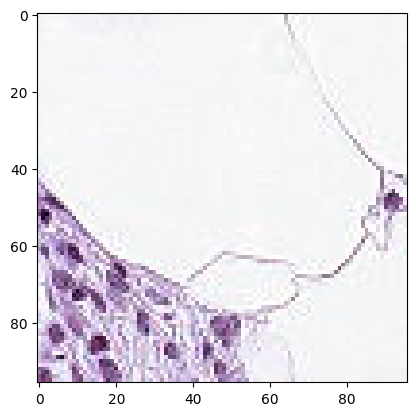

In [12]:
fileId= train_data_csv['id'][0]
target = train_data_csv['label'][0]
f=glob('/content/train/'+ fileId+'.tif')[0]
print(f)
im = cv2.imread(f)
print(im.shape)
plt.imshow(im)

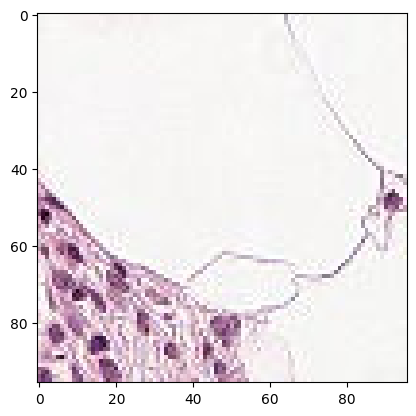

In [ ]:
plt.imshow(im[:,:,::-1])

In [26]:
data_dir='/content/train/'

class CancerDetectionDataset(Dataset):
    def __init__(self, folder, df):
      self.df= df.reset_index(drop=True)
      #negative_df = df[df['label'] == 1].head(1000)
      #positive_df = df[df['label'] == 0].head(1000)
      self.folder = folder
      self.normalize= transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    def __len__(self):
      return len(self.df)
    def __getitem__(self, ix):
      fileId= self.df['id'][ix]
      target = self.df['label'][ix]
      f=glob(self.folder + fileId+'.tif')[0]
      im = cv2.imread(f)[:,:,::-1]
      # im = cv2.resize(im, (224,224))
      im=torch.tensor(im/255)
      im = im.permute(2,0,1) #NCHW
      im=self.normalize(im)
      return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
data= CancerDetectionDataset(data_dir, train_data_csv)
data[1]

In [28]:
def get_model():
  model=models.vgg16(pretrained=False).to(device)
  model.load_state_dict(torch.load(model_path, map_location=device))
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool= nn.AdaptiveAvgPool2d(output_size = (1,1)) #1*1*512 # why didn't we go with inherent 7*7
  model.classifier= nn.Sequential(nn.Flatten(),
                                  nn.Linear(512,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(128,1),
                                  nn.Sigmoid())

  loss_fn= nn.BCELoss()
  optimizer= torch.optim.Adam(model.parameters(), lr = 1e-3)
  return model.to(device), loss_fn, optimizer

In [32]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_data_csv, test_size=0.2, random_state=42)

train_dataset= CancerDetectionDataset(data_dir, train_df)
test_dataset= CancerDetectionDataset(data_dir, test_df)
train_dataloader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model, loss_fn, optimizer= get_model()
def accuracy(prediction, targets):
  is_correct = (prediction > 0.5) == targets
  return is_correct.cpu().numpy().sum()/targets.size(0)

def train(model, dataloader, optimize, criterion):
  model.train()
  train_loss=0
  train_acc=0
  for inputs, targets in dataloader:
    optimizer.zero_grad()
    outputs= model(inputs)
    loss= criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss+= loss.item()
    train_acc+= accuracy(outputs, targets)
  return train_loss/len(dataloader), train_acc/len(dataloader)

def validate(model, dataloader, criterion):
  model.eval()
  val_loss=0
  val_acc=0
  with torch.no_grad():
    for inputs, targets in dataloader:
      outputs= model(inputs)
      loss= criterion(outputs, targets)
      val_loss+= loss.item()
      val_acc+= accuracy(outputs, targets)
  return val_loss/ len(dataloader), val_acc / len(dataloader)

In [ ]:
n_epochs= 10
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
for epoch in range(n_epochs):
  print(f"Epoch {epoch+1}/{n_epochs}")

  train_loss, train_acc= train(model, train_dataloader, optimizer, loss_fn)
  val_loss, val_acc= validate(model, test_dataloader, loss_fn)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.6599 Train Acc: 0.6075
Val Loss: 0.6689 Val Acc: 0.5889
Epoch 2/10
Train Loss: 0.6577 Train Acc: 0.6075
Val Loss: 0.6639 Val Acc: 0.5889
Epoch 3/10
Train Loss: 0.6546 Train Acc: 0.6075
Val Loss: 0.6606 Val Acc: 0.5889
Epoch 4/10
Train Loss: 0.6490 Train Acc: 0.6075
Val Loss: 0.6600 Val Acc: 0.5889
Epoch 5/10
Train Loss: 0.6443 Train Acc: 0.6075
Val Loss: 0.6499 Val Acc: 0.5889
Epoch 6/10
Train Loss: 0.6385 Train Acc: 0.6075
Val Loss: 0.6454 Val Acc: 0.5889
Epoch 7/10
Train Loss: 0.6332 Train Acc: 0.6088
Val Loss: 0.6367 Val Acc: 0.6106
Epoch 8/10
Train Loss: 0.6220 Train Acc: 0.6144
Val Loss: 0.6273 Val Acc: 0.5889
Epoch 9/10
Train Loss: 0.6111 Train Acc: 0.6300
Val Loss: 0.6174 Val Acc: 0.6755
Epoch 10/10
